# Setup

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import os
import numpy as np

# to make this notebook's output stable across runs
np.random.seed(42)

# Plot figures
%matplotlib inline
import matplotlib        as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)




# save figures
ROOT_DIR = "."
DIR      = "random_forests"
FIG_PATH = os.path.join(ROOT_DIR, "images", DIR)

os.makedirs(FIG_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(os.path.join(FIG_PATH, fig_id + "." + fig_extension),\
                bbox_inches='tight',\
                pad_inches=0.09,\
                format=fig_extension,\
                dpi=resolution)

In [ ]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, x_axis=[-1.5, 2.45], y_axis=[-1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(x_axis[0], x_axis[1], 100)
    x2s = np.linspace(y_axis[0], y_axis[1], 100)

    x1, x2 = np.meshgrid(x1s, x2s)
    X_new  = np.c_[x1.ravel(), x2.ravel()]
    
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)

    plt.xlim(x_axis)
    plt.ylim(y_axis)

    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

**Suppose you pose a complex question to thousands of random people, then aggregate their answers. In many cases you will find that this aggregated answer is better than an expert’s answer. This is called the wisdom of the crowd. Similarly, if you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. A group of predictors is called an ensemble; thus, this technique is called Ensemble Learning, and an Ensemble Learning algorithm is called an Ensemble method.**


**As an example of an Ensemble method, you can train a group of Decision Tree classifiers, each on a different random subset of the training set. To make predictions, you obtain the predictions of all the individual trees, then predict the class that gets the most votes (see the last exercise in Chapter 6). Such an ensemble of Decision Trees is called a Random Forest, and despite its simplicity, this is one of the most powerful Machine Learning algorithms available today.**

# Random Forests

**A Random Forest is an ensemble of Decision Trees, generally trained via the bagging method (or sometimes pasting), typically with max_samples set to the size of the training set. Instead of building a BaggingClassifier and passing it a DecisionTreeClassifier, you can instead use the RandomForestClassifier class, which is more convenient and optimized for Decision Trees10 (similarly, there is a RandomForestRegressor class for regression tasks). The following code uses all available CPU cores to train a Random Forest classifier with 500 trees (each limited to maximum 16 nodes):**

**Data**

In [ ]:
from sklearn.datasets        import make_moons
from sklearn.model_selection import train_test_split

# data
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

# split to training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

**Bagging Classifier + DecisionTreeClassifier**

In [ ]:
# BaggingClassifier
# The following BaggingClassifier is equivalent to the RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
                             DecisionTreeClassifier(splitter="random",
                                                    max_leaf_nodes=16,
                                                    random_state=42
                                                   ),
                             n_estimators=500,
                             max_samples=1.0,
                             bootstrap=True,
                             random_state=42
                           )

In [ ]:
# Training
bag_clf.fit(X_train, y_train)

# Predicting
y_pred_bag = bag_clf.predict(X_test)

**Random Forest Classifier**

In [ ]:
from sklearn.ensemble.forest import RandomForestClassifier

# RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)

# training
rnd_clf.fit(X_train, y_train)

# predict
y_pred_rf = rnd_clf.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# Check the consistency of the two classifiers
np.sum(y_pred_bag == y_pred_rf) / len(y_pred_bag)  # almost identical predictions

0.976

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [ ]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

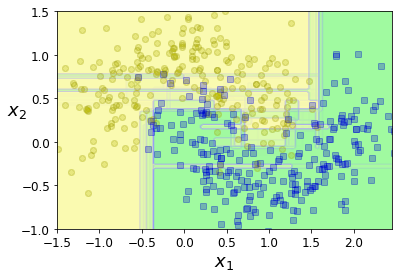

In [ ]:
# Figure
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)

    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))

    # Training
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])

    # Plot
    plot_decision_boundary(tree_clf, X, y, x_axis=[-1.5, 2.45], y_axis=[-1, 1.5], alpha=0.02, contour=False)

plt.show()

## **Extra-Trees**

## **Extremely Randomized Trees ensemble**

**When you are growing a tree in a Random Forest, at each node only a random subset of the features is considered for splitting (as discussed earlier). It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible thresholds (like regular Decision Trees do).**

**A forest of such extremely random trees is called an Extremely Randomized Trees ensemble12 (or Extra-Trees for short). Once again, this technique trades more bias for a lower variance. It also makes Extra-Trees much faster to train than regular Random Forests, because finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree.**

**You can create an Extra-Trees classifier using Scikit-Learn’s ExtraTreesClassifier class. Its API is identical to the RandomForestClassifier class. Similarly, the ExtraTreesRegressor class has the same API as the RandomForestRegressor class.**

**TIP:**

**It is hard to tell in advance whether a RandomForestClassifier will perform better or worse than an ExtraTreesClassifier. Generally, the only way to know is to try both and compare them using cross-validation (tuning the hyperparameters using grid search).**

## **Feature importance**

**Yet another great quality of Random Forests is that they make it easy to measure the relative importance of each feature. Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest). More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it.**

**Scikit-Learn computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1. You can access the result using the feature_importances_ variable. For example, the following code trains a RandomForestClassifier on the iris dataset and outputs each feature’s importance. It seems that the most important features are the petal length (44%) and width (42%), while sepal length and width are rather unimportant in comparison (11% and 2%, respectively):**

In [ ]:
from sklearn.datasets import fetch_openml

mnist        = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [ ]:
# Model and training the model
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


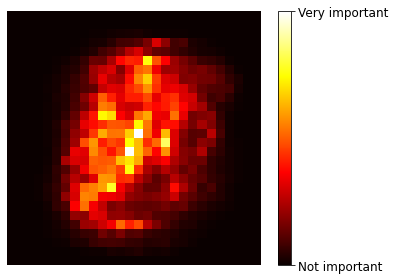

In [ ]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

**Random Forests are very handy to get a quick understanding of what features actually matter, in particular if you need to perform feature selection.**